In [1]:
%matplotlib inline
import sys, srwl_bl
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

In [2]:
from __future__ import print_function #Python 2.7 compatibility
from srwlib import *
from srwl_uti_smp import *
from uti_plot import * #required for plotting
from wpg import Wavefront
import copy, os, sys, time
import numpy as np
import pylab as plt

In [3]:
''' auxiliary function '''
def E2L(e):
    hbar = 6.582119569e-16
    omega = e/hbar
    frequency = omega /2/np.pi
    wavelength = 3e8/frequency
    return wavelength

def E2k(e):
    wavelength = E2L(e)
    k = 2*np.pi/wavelength
    return k

def mkdir(path):
    """
    Create directory with subfolders (like Linux mkdir -p)

    :param path: Path to be created
    """
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise

def plot_spatial_from_wf(wf):
    srwl.SetRepresElecField(wf._srwl_wf, 't')
    [xmin, xmax, ymin, ymax] = wf.get_limits()
    img = wf.get_intensity().sum(axis=-1)
    plt.imshow(img,cmap='jet',
        extent = [xmin*1e6, xmax*1e6, ymin*1e6, ymax*1e6])
    plt.colorbar()
    plt.xlabel(r'x ($\mu$m)',fontsize=18)
    plt.ylabel(r'y ($\mu$m)',fontsize=18)

def get_temporal(wf):
    # change the wavefront into time domain, where each slice in z represent a time
    srwl.SetRepresElecField(wf._srwl_wf, 't')
    mesh = wf.params.Mesh
    dx = (mesh.xMax - mesh.xMin) / (mesh.nx - 1)        # spatial sampling resolution
    dy = (mesh.yMax - mesh.yMin) / (mesh.ny - 1)
    int0 = wf.get_intensity().sum(axis=0).sum(axis=0)   # intensity per slice
    #int0_00 = wf.get_intensity()[int(mesh.ny/2), int(mesh.nx/2),:]  # central intensity
    dSlice = (mesh.sliceMax - mesh.sliceMin)/(mesh.nSlices-1)   # time sampling resolution
    axis_t = np.arange(mesh.nSlices) * dSlice + mesh.sliceMin  # time axis

    # get meaningful slices (>1% maximum intensity)
    int0max = max(int0)                                 # maximum intensity slice
    aw = [a[0] for a in np.argwhere(int0>int0max*0.01)] # meaningful indices
    aw = np.asarray(aw)
    #int0_mean = int0[min(aw):max(aw)]                   # meaningful intensity slices
    #axis_t = np.arange(min(aw),max(aw)) * dSlice + mesh.sliceMin # meaningful time axis
    return aw, axis_t, int0

def get_tilt(wf, ori='V'):
    srwl.SetRepresElecField(wf._srwl_wf, 't')
    [xmin, xmax, ymin, ymax] = wf.get_limits()
    mesh = wf.params.Mesh
    if ori == 'V':
        axis = np.linspace(ymin, ymax, mesh.ny)
        tilt = wf.get_intensity()[:,int(mesh.nx/2),:]
    else:
        axis = np.linspace(xmin, xmax, mesh.nx)
        tilt = wf.get_intensity()[int(mesh.ny/2),:,:]
    return axis, tilt

def plot_tilt(axis, tilt, axis_t, label=None, ori='V', if_log=0):
    tilt = tilt/tilt.max()
    tilt = tilt + 1e-30
    if ori == 'V':
        alabel = 'y'
    else:
        alabel = 'x'
    title = 'wavefront tilt at '+label
    if if_log == 1:
        tilt = np.log(tilt)
        title = title+', log'
    plt.imshow(tilt, cmap='jet',
              extent = [axis_t.max()*1e15, axis_t.min()*1e15, axis.max()*1e6, axis.min()*1e6])
    plt.colorbar()
    if if_log == 1:
        cmin = np.max(tilt)-10
        plt.clim(cmin)
    plt.axis('tight')
    plt.title(title, fontsize=18)
    plt.xlabel('time (fs)', fontsize=18)
    plt.ylabel(alabel+r' ($\mu$m)', fontsize=18)

def plot_tilt_from_wf(wf, label=None, ori='V', if_log=0):
    axis, tilt = get_tilt(wf, ori=ori)
    _, axis_t, _ = get_temporal(wf)
    plot_tilt(axis, tilt, axis_t, label=label, ori=ori, if_log=if_log)
    
def get_axis_ev(wf):
    srwl.SetRepresElecField(wf._srwl_wf, 'f')
    mesh = wf.params.Mesh
    if mesh.nSlices == 1:
        axis_ev = np.asarray([mesh.sliceMax])
    else:
        axis_ev = np.arange(mesh.nSlices) * (mesh.sliceMax - mesh.sliceMin)/(mesh.nSlices-1) + mesh.sliceMin
    srwl.SetRepresElecField(wf._srwl_wf, 't')
    return axis_ev

def get_refractive_index(axis_ev):
    cxro_data = np.genfromtxt('Be.csv',delimiter=',')
    ev = cxro_data[:,0]
    delta = cxro_data[:,1]
    beta = cxro_data[:,2]
    
    delta1 = np.interp(get_axis_ev(mwf), ev, delta)
    beta1 = np.interp(get_axis_ev(mwf), ev, beta)
    return delta1, beta1

def set_crystal_orient(cryst, e, ang_dif_pl, flip=0):
    if flip == 1:
        ang_dif_pl = ang_dif_pl+np.pi
    nvx, nvy, nvz = cryst.find_orient(
        e,ang_dif_pl)[0][2]             # outward normal vector to crystal surface
    tvx, tvy, _ = cryst.find_orient(
        e,ang_dif_pl)[0][0]      # central tangential vector
    cryst.set_orient(nvx,nvy,nvz,tvx,tvy)
    

RMS Source Size: 9.787 um; RMS Divergence: 1.063 urad
R-space
R-space


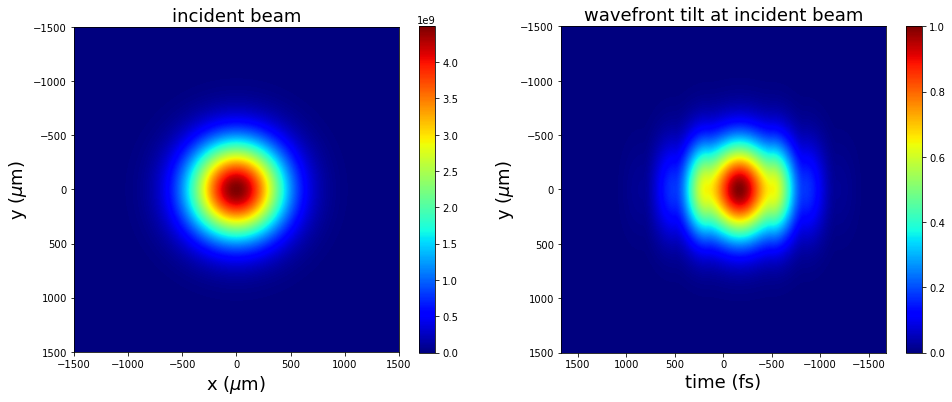

In [4]:
''' build incident Gaussian beam '''
#***********Sampling parameters
nx = 100
ny = 100
nz = 10

z_source = 630.
z_CRL0 = z_source+290.
range_xy = 3e-3

ekev = 9.481
sigT = 400e-15
bw = 10e-3         # bandwidth [eV]

#***********Gaussian Beam Source
GsnBm = SRWLGsnBm() #Gaussian Beam structure (just parameters)
GsnBm.x = 0 #Transverse Positions of Gaussian Beam Center at Waist [m]
GsnBm.y = 0
GsnBm.z = z_source #Longitudinal Position of Waist [m]
GsnBm.xp = 0 #Average Angles of Gaussian Beam at Waist [rad]
GsnBm.yp = 0
GsnBm.avgPhotEn = ekev*1e3 #Photon Energy [eV]
GsnBm.pulseEn = 0.001 #Energy per Pulse [J] - to be corrected
GsnBm.repRate = 1 #Rep. Rate [Hz] - to be corrected
GsnBm.polar = 1 #1- linear horizontal
GsnBm.sigX = 23.e-6/2.35 #Horiz. RMS size at Waist [m]
GsnBm.sigY = GsnBm.sigX #Vert. RMS size at Waist [m]

constConvRad = 1.23984186e-06/(4*3.1415926536)
rmsAngDiv = constConvRad/(GsnBm.avgPhotEn*GsnBm.sigX) #RMS angular divergence [rad]
print('RMS Source Size:', round(GsnBm.sigX*1.e+06, 3), 'um; RMS Divergence:', round(rmsAngDiv*1.e+06, 3), 'urad')

GsnBm.sigT = sigT #Pulse duration [fs] (not used?)
GsnBm.mx = 0 #Transverse Gauss-Hermite Mode Orders
GsnBm.my = 0

#***********Initial Wavefront
wfr = SRWLWfr() #Initial Electric Field Wavefront
wfr.allocate(nz, nx, ny) #Numbers of points vs Photon Energy (1), Horizontal and Vertical Positions (dummy)
wfr.mesh.zStart = z_CRL0 #Longitudinal Position [m] at which initial Electric Field has to be calculated, i.e. the position of the first optical element
wfr.mesh.eStart = GsnBm.avgPhotEn-bw/2 #Initial Photon Energy [eV]
wfr.mesh.eFin = GsnBm.avgPhotEn+bw/2 #Final Photon Energy [eV]
wfr.unitElFld = 1 #Electric field units: 0- arbitrary, 1- sqrt(Phot/s/0.1%bw/mm^2), 2- sqrt(J/eV/mm^2) or sqrt(W/mm^2), depending on representation (freq. or time)

#Horizontal and Vertical Position Range for the Initial Wavefront calculation
firstHorAp = range_xy #[m]
firstVertAp = firstHorAp #[m]
wfr.mesh.xStart = -0.5*firstHorAp #Initial Horizontal Position [m]
wfr.mesh.xFin = 0.5*firstHorAp #Final Horizontal Position [m]
wfr.mesh.yStart = -0.5*firstVertAp #Initial Vertical Position [m]
wfr.mesh.yFin = 0.5*firstVertAp #Final Vertical Position [m]

sampFactNxNyForProp = 3 #sampling factor for adjusting nx, ny (effective if > 0)
arPrecPar = [sampFactNxNyForProp]

wfr.partBeam.partStatMom1.x = GsnBm.x #Some information about the source in the Wavefront structure
wfr.partBeam.partStatMom1.y = GsnBm.y
wfr.partBeam.partStatMom1.z = GsnBm.z
wfr.partBeam.partStatMom1.xp = GsnBm.xp
wfr.partBeam.partStatMom1.yp = GsnBm.yp

#***********Calculate initial wavefront
srwl.CalcElecFieldGaussian(wfr, GsnBm, arPrecPar)

mwf = Wavefront(wfr)

if nz == 1:
    plt.figure()
    plot_spatial_from_wf(mwf)
    plt.title('incident beam', fontsize=18)
else: 
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plot_spatial_from_wf(mwf)
    plt.title('incident beam', fontsize=18)

    plt.subplot(1,2,2)
    plot_tilt_from_wf(mwf, label='incident beam', ori='V', if_log = 0)

In [5]:
''' Beamline components '''
f_CRL0 = 290.
f_CRL = 10.
z_CRL0 = z_source + f_CRL0
z_C1 = 930
z_C2 = z_C1+.2
z_CRL1 = z_C2 + f_CRL
z_Slit = z_CRL1 + f_CRL
z_CRL2 = z_Slit + f_CRL
z_C3 = z_CRL2+f_CRL
z_C4 = z_C3+.2
z_output = z_C4+.2

''' CRL
     srwl_opt_setup_CRL(_foc_plane, _delta, _atten_len, _shape, _apert_h, _apert_v,
                        _r_min, _n, _wall_thick, _xc, _yc,
                        _void_cen_rad=None, _e_start=0, _e_fin=0, _nx=1001, _ny=1001, _ang_rot_ex=0, _ang_rot_ey=0)
'''
axis_ev_crl = get_axis_ev(mwf)

delta_crl, beta_crl =  get_refractive_index(axis_ev_crl)
atten_len_crl = 1/beta_crl/E2k(ekev*1e3)
atten_len_crl = np.ones_like(delta_crl)*1e30

foc_plane = 3
delta = delta_crl.tolist()
atten_len = atten_len_crl.tolist()

e_start = axis_ev_crl.min()
e_fin = axis_ev_crl.max()
sizex_lens = 2e-3
sizey_lens = sizex_lens
nx_lens = 1001
ny_lens = nx_lens

CRL0 = srwl_opt_setup_CRL(foc_plane, delta, atten_len, 1, sizex_lens, sizey_lens,
                          2.1989112771191284e-3,1, 5e-5, 0.0, 0.0,
                          _e_start=e_start, _e_fin=e_fin, _nx=nx_lens, _ny=ny_lens)

CRL1 = srwl_opt_setup_CRL(foc_plane, delta, atten_len, 1, sizex_lens, sizey_lens,
                          7.582452679721133e-05,1, 5e-5, 0.0, 0.0,
                          _e_start=e_start, _e_fin=e_fin, _nx=nx_lens, _ny=ny_lens)

CRL2 = srwl_opt_setup_CRL(foc_plane, delta, atten_len, 1, sizex_lens, sizey_lens,
                          7.582452679721133e-05,1, 5e-5, 0.0, 0.0,
                          _e_start=e_start, _e_fin=e_fin, _nx=nx_lens, _ny=ny_lens)

''' Crystal
        SRWLOptCryst(_d_sp, _psi0r, _psi0i,
                    _psi_hr, _psi_hi,
                    _psi_hbr, _psi_hbi,
                    _tc, _ang_as,
                    _nvx=0, _nvy=0, _nvz=-1,
                    _tvx=1, _tvy=0, _uc=1)
'''
C1 = SRWLOptCryst(0.9600687344008111, -1.0873035035585694e-05, 1.8438837339536554e-07,
                  -4.181686438547451e-06, 1.6100412693351052e-07,
                  -4.181686438547451e-06, 1.6100412693351052e-07,
                  0.01, 0,
                  _nvx=-0.7322282430733594, _nvy=4.975415277322606e-09, _nvz=-0.6810593219725439,
                  _tvx=-0.6810593219725439, _tvy=4.627727743855522e-09, _uc=1)

C2 = SRWLOptCryst(0.9600687344008111, -1.0873035035585694e-05, 1.8438837339536554e-07,
                  -4.181686438547451e-06, 1.6100412693351052e-07,
                  -4.181686438547451e-06, 1.6100412693351052e-07,
                  0.01, -0.6619756915046209,
                  _nvx=0.158940316609, _nvy=1.08e-09, _nvz=-0.987288192858,
                  _tvx=0.987288192858, _tvy=6.709e-09, _uc=1)

C3 = SRWLOptCryst(0.9600687344008111, -1.0873035035585694e-05, 1.8438837339536554e-07,
                  -4.181686438547451e-06, 1.6100412693351052e-07,
                  -4.181686438547451e-06, 1.6100412693351052e-07,
                  0.01, 0,
                  _nvx=0.732228243073, _nvy=4.975e-09, _nvz=-0.681059321973,
                  _tvx=0.681059321973, _tvy=4.628e-09, _uc=1)

C4 = SRWLOptCryst(0.9600687344008111, -1.0873035035585694e-05, 1.8438837339536554e-07,
                  -4.181686438547451e-06, 1.6100412693351052e-07,
                  -4.181686438547451e-06, 1.6100412693351052e-07,
                  0.01, 0.6619756915046209,
                  _nvx=-0.996192732149, _nvy=6.769e-09, _nvz=-0.087178210659,
                  _tvx=-0.087178210659, _tvy=5.92e-10, _uc=1)

ang_dif_pl = np.pi/2
set_crystal_orient(C1, ekev*1e3, ang_dif_pl, flip=0)
set_crystal_orient(C2, ekev*1e3, ang_dif_pl, flip=1)
set_crystal_orient(C3, ekev*1e3, ang_dif_pl, flip=1)
set_crystal_orient(C4, ekev*1e3, ang_dif_pl, flip=0)

''' Slit
        SRWLOptA(_shape='r', _ap_or_ob='a', _Dx=0, _Dy=0, _x=0, _y=0)
'''
Slit = SRWLOptA('r', 'a', _Dx=200e-6, _Dy=10e-3, _x=0.0, _y=0.0)


Optical Element Setup: CRL Focal Length: 290.0 m
Optical Element Setup: CRL Focal Length: 10.0 m
Optical Element Setup: CRL Focal Length: 10.0 m


Text(0.5, 1.0, 'CRL2 [nm]')

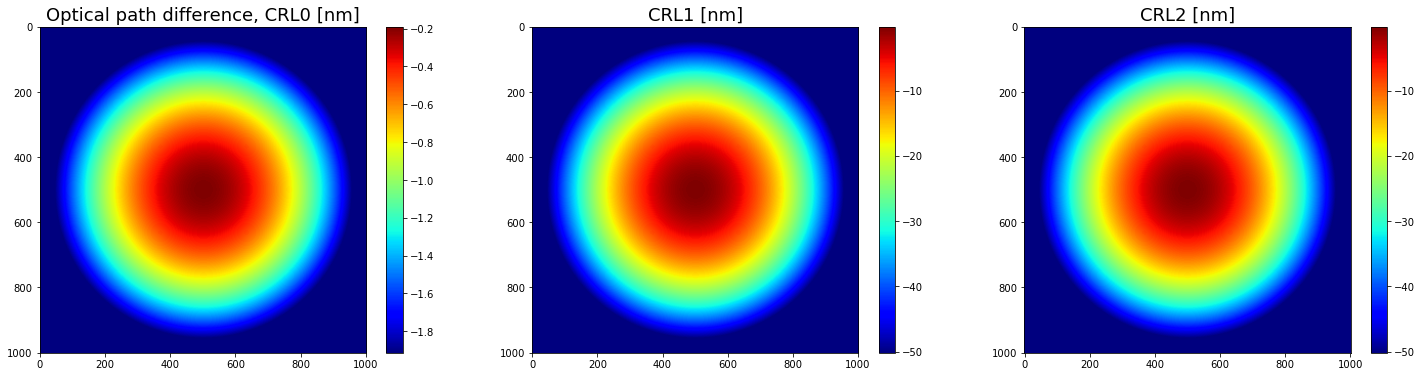

In [6]:
''' Lens demo '''
opd0=np.array(CRL0.arTr)[1::2].reshape(CRL0.mesh.ny,CRL0.mesh.nx,CRL0.mesh.ne)
opd1=np.array(CRL1.arTr)[1::2].reshape(CRL1.mesh.ny,CRL1.mesh.nx,CRL1.mesh.ne)
opd2=np.array(CRL2.arTr)[1::2].reshape(CRL2.mesh.ny,CRL2.mesh.nx,CRL2.mesh.ne)
plt.figure(figsize=(25,6))

plt.subplot(1,3,1)
plt.imshow(opd0[:,:,0]*1e9,cmap='jet')
plt.colorbar()
plt.title('Optical path difference, CRL0 [nm]', fontsize=18)

plt.subplot(1,3,2)
plt.imshow(opd1[:,:,0]*1e9,cmap='jet')
plt.colorbar()
plt.title('CRL1 [nm]', fontsize=18)

plt.subplot(1,3,3)
plt.imshow(opd2[:,:,0]*1e9,cmap='jet')
plt.colorbar()
plt.title('CRL2 [nm]', fontsize=18)


In [7]:
''' Drifts '''
CRL0_to_C1   = SRWLOptD(z_C1-z_CRL0)
C1_to_C2     = SRWLOptD(z_C2-z_C1)
C2_to_CRL1   = SRWLOptD(z_CRL1-z_C2)
CRL1_to_Slit = SRWLOptD(z_Slit-z_CRL1)
Slit_to_CRL2 = SRWLOptD(z_CRL2-z_Slit)
CRL2_to_C3   = SRWLOptD(z_C3-z_CRL2)
C3_to_C4     = SRWLOptD(z_C4-z_C3)
C4_to_output = SRWLOptD(z_output-z_C4)

''' Propagation method '''
#                  [0][1] [2] [3][4] [5]  [6]  [7]  [8]  [9] [10] [11] [12] [13] [14] [15] [16] 
pp_im0_to_CRL0 =  [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_CRL0 =         [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_CRL0_to_C1 =   [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_C1 =           [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_C1_to_C2 =     [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_C2 =           [0, 0, 1.0, 0, 0, 10.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0] #
pp_C2_to_CRL1 =   [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_CRL1 =         [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_CRL1_to_Slit = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_Slit =         [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_Slit_to_CRL2 = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_CRL2 =         [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_CRL2_to_C3 =   [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_C3 =           [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_C3_to_C4 =     [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_C4 =           [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
pp_C4_to_output = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]

#[ 0]: Auto-Resize (1) or not (0) Before propagation
#[ 1]: Auto-Resize (1) or not (0) After propagation
#[ 2]: Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[ 3]: Allow (1) or not (0) for semi-analytical treatment of the quadratic (leading) phase terms at the propagation
#[ 4]: Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[ 5]: Horizontal Range modification factor at Resizing (1. means no modification)
#[ 6]: Horizontal Resolution modification factor at Resizing
#[ 7]: Vertical Range modification factor at Resizing
#[ 8]: Vertical Resolution modification factor at Resizing
#[ 9]: Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#[12]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Horizontal Coordinate
#[13]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Vertical Coordinate
#[14]: Optional: Orientation of the Output Optical Axis vector in the Incident Beam Frame: Longitudinal Coordinate
#[15]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Horizontal Coordinate
#[16]: Optional: Orientation of the Horizontal Base vector of the Output Frame in the Incident Beam Frame: Vertical Coordinate


In [8]:
''' Beamline '''
optBL0 = SRWLOptC([CRL0, CRL0_to_C1],
               
               [pp_CRL0, pp_CRL0_to_C1])

optBL1 = SRWLOptC([C1, C1_to_C2],
               
               [pp_C1, pp_C1_to_C2])

optBL2 = SRWLOptC([C2_to_CRL1, CRL1, CRL1_to_Slit, Slit,
                Slit_to_CRL2, CRL2, CRL2_to_C3, C3,
                C3_to_C4, C4, C4_to_output],
               
               [pp_C2_to_CRL1, pp_CRL1, pp_CRL1_to_Slit, pp_Slit,
                pp_Slit_to_CRL2, pp_CRL2, pp_CRL2_to_C3, pp_C3,
                pp_C3_to_C4, pp_C4, pp_C4_to_output])


propagation lasted: 3.41s
R-space


array([[[4.26594369e-07, 9.64309961e+03, 1.52946562e+04, ...,
         8.50300700e+06, 1.74516812e+06, 4.46043488e+02],
        [6.35082245e-07, 8.60210547e+03, 5.57468359e+04, ...,
         9.72205100e+06, 1.32025288e+06, 1.83222363e+03],
        [1.43089167e-07, 1.01522656e+04, 1.10626617e+05, ...,
         1.13230660e+07, 1.16857300e+06, 4.23643945e+03],
        ...,
        [3.77964824e-07, 3.79198906e+04, 8.40724219e+04, ...,
         5.92009850e+06, 5.76512450e+06, 4.30669482e+03],
        [1.03130446e-06, 2.49428301e+04, 3.87966367e+04, ...,
         6.66185700e+06, 3.90833600e+06, 1.76433118e+03],
        [3.09591769e-07, 1.49583984e+04, 9.33429980e+03, ...,
         7.52000350e+06, 2.57311775e+06, 4.10001038e+02]],

       [[6.35082245e-07, 8.60210254e+03, 5.57468555e+04, ...,
         9.72205300e+06, 1.32025200e+06, 1.83222375e+03],
        [1.09806922e-06, 9.60688281e+03, 1.53767219e+05, ...,
         1.12662030e+07, 9.22525875e+05, 3.82251953e+03],
        [6.90214904e-07, 

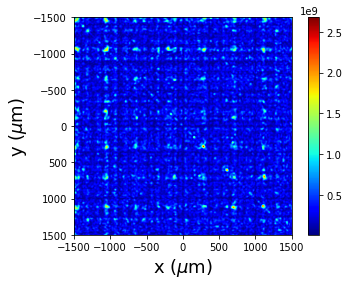

In [9]:
''' Propagation through CRL0 '''
tstart = time.time()
srwl.PropagElecField(wfr, optBL0)
print('propagation lasted: {}s'.format(round(time.time() - tstart,2)))

mwf_out = Wavefront(wfr)
plot_spatial_from_wf(mwf_out)

#plt.xlim([-2500,2500])
mwf_out.get_intensity()

propagation lasted: 6.61s
R-space


array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

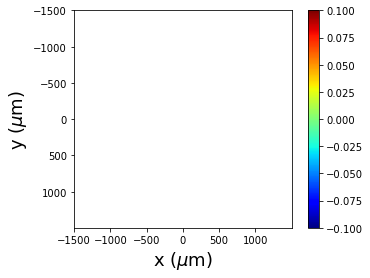

In [10]:
''' Propagation through Crystal 1 '''
tstart = time.time()
srwl.PropagElecField(wfr, optBL1)
print('propagation lasted: {}s'.format(round(time.time() - tstart,2)))

mwf_out = Wavefront(wfr)
plot_spatial_from_wf(mwf_out)

#plt.xlim([-2500,2500])
mwf_out.get_intensity()

propagation lasted: 19.31s
R-space


ValueError: Axis limits cannot be NaN or Inf

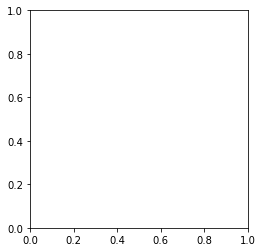

In [11]:
''' Propagation through rest of beamline '''
tstart = time.time()
srwl.PropagElecField(wfr, optBL2)
print('propagation lasted: {}s'.format(round(time.time() - tstart,2)))

mwf_out = Wavefront(wfr)
plot_spatial_from_wf(mwf_out)

#plt.xlim([-2500,2500])
mwf_out.get_intensity()
